In [2]:
from simnibs import sim_struct, run_simnibs
import nilearn.image as img
import nilearn.plotting as niplot
import os
import numpy as np
from numpy import degrees, arcsin, arctan2, deg2rad, cos, sin
from simnibs.msh import mesh_io
import simnibs.msh.transformations as transformations

## Calculating Distances between Intended Target and Maximal E-Field

This is a three-step process:

1. We'll need to identify the part of the cortex directly under the TMS coil
2. We'll need to identify the part of the cortex that undergoes maximal stimulation
3. Calculate the euclidean distance between the two coordinates


### Calculating coordinates directly under the TMS coil

This can be accomplished via:

1. Obtaining our TMS scalp coordinate
2. Using the normal of the TMS coil position to intercept the cortex

First we'll get our scalp coordinate

In [3]:
mesh = mesh_io.read_msh('../output/msn__1-0001_MagVenture_MC_B70.nii_scalar.msh')

m2m_dir = "../data/m2m_sub-CMHP001/"
coords = [-30, 43, 23]
xfm_res = transformations.warp_coordinates(
    coordinates=coords,m2m_folder=m2m_dir,
    transformation_direction='mni2subject')

subject_ldlpfc = xfm_res[1]
subject_dlpfc_scalp = transformations.project_on_scalp(
    coords = subject_ldlpfc,
    mesh=mesh,
    distance=1
)

print(subject_dlpfc_scalp)

[[-45.13417276  43.07987477  72.64537813]]


Then we calculate the normal as we've done when specifying the coil coordinate

In [4]:
closest_node, node_index = mesh.nodes.find_closest_node([subject_dlpfc_scalp],
                                           return_index=True)
print(closest_node, node_index)

# Extract from list of list
node_index = node_index[0][0]

[[[-44.440907  42.625675  72.085838]]] [[403303]]


In [5]:
node_normal = mesh.nodes_normals(smooth=2).value[node_index]
print(node_normal)

[-0.69374112  0.45589802  0.55756636]


We will find the coordinate of the cortex where the TMS coil is "pointing" via using ray intersection. To perform ray intersection we need to specify:

1. A starting coordinate (our TMS coil)
2. An end coordinate for the ray (a long line of arbitrary length)

SimNIB's ray interception algorithm will give us the first hit (i.e the closest coordinate that intercepts the way)

In [6]:
# Only pull grey matter (2 is for volume, 1002 is for surface)
gm = mesh.crop_mesh(tags=(2,1002))

# Start at TMS coil
start = subject_dlpfc_scalp.flatten()

# Project into the head using a long line
# The first intersection will be returned!
end = (subject_dlpfc_scalp + -100 * node_normal).flatten()

cortex_node, cortex_coordinate = gm.intercept_ray(start, end)

In [7]:
print(cortex_coordinate)

[-36.5493246   37.43826707  65.7456537 ]


Let's verify our result:

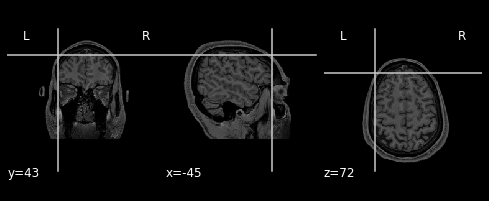

In [22]:
t1 = img.load_img('../data/m2m_sub-CMHP001/T1fs_nu_conform.nii.gz')
niplot.plot_anat(t1,
                cut_coords=subject_dlpfc_scalp[0])

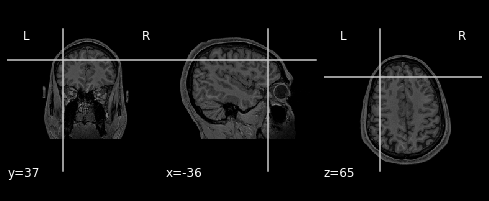

In [23]:
niplot.plot_anat(t1,
                cut_coords=cortex_coordinate)

Looks good! However it is important to note that the ray interception algorithm is *unstable*. Meaning that you may accidentally hit the side of a gyral fold rather than the crown which is typically the TMS target. 

The result is that your calculations may be off by a very small amount. If you want to correct for this small deviation see the end of the notebook to make this estimate more robust

## Obtaining coordinates of maximal stimulation intensity

Obtaining the region of maximal stimulation intensity can be done via loading in the simulation data, and querying the mesh

In [89]:
# Get only volume results
efield_msh = mesh.crop_mesh([2],elm_type=[4])

In [53]:
print(efield_msh.fields_summary())

Field Percentiles
-----------------
Top percentiles of the field (or field norm for vector fields)
|Field |99.9%         |99.0%         |95.0%         |
|------|--------------|--------------|--------------|
|E     |4.55e+00 V/m  |1.63e+00 V/m  |4.02e-01 V/m  |
|normE |4.55e+00 V/m  |1.63e+00 V/m  |4.02e-01 V/m  |
|J     |2.20e+00 A/m² |5.98e-01 A/m² |1.05e-01 A/m² |
|normJ |2.20e+00 A/m² |5.98e-01 A/m² |1.05e-01 A/m² |

Field Focality
---------------
Mesh volume or area with a field >= X% of the 99.9th percentile
|Field |75.0%        |50.0%        |
|------|-------------|-------------|
|E     |6.17e+03 mm³ |1.68e+04 mm³ |
|normE |6.17e+03 mm³ |1.68e+04 mm³ |
|J     |6.92e+03 mm³ |1.28e+04 mm³ |
|normJ |6.92e+03 mm³ |1.28e+04 mm³ |



In [90]:
# Get coordinates and Efield magnitudes
coords = efield_msh.elements_baricenters().value
data = efield_msh.field['normE'].value

In [91]:
# Identify peak stimulation coordinate
maximum_ind = np.argmax(data)
peak_coord = coords[maximum_ind, :]

## Calculating Distance

In [92]:
# In mm
np.linalg.norm(peak_coord - cortex_coordinate)

42.995738660521695